# Spark Exploration

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## Exercise 1
How many different cases are there, by department?

In [2]:
dept_cases = df.groupBy('department').count()
dept_cases.show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



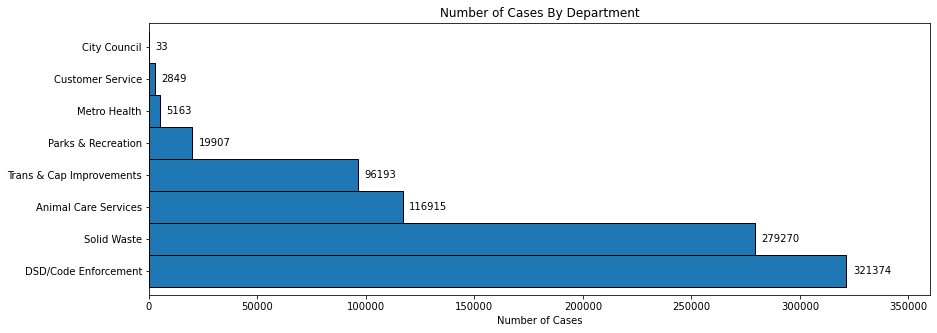

In [41]:
case_count = (
    df.groupBy("department")
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
)

case_count.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")
plt.xlim(0, 360000)

for index, width in enumerate(case_count):
    plt.text(width+3000, index, width, va="center")
    
plt.show()

In [29]:
case_count

department
DSD/Code Enforcement        321374
Solid Waste                 279270
Animal Care Services        116915
Trans & Cap Improvements     96193
Parks & Recreation           19907
Metro Health                  5163
Customer Service              2849
City Council                    33
Name: count, dtype: int64

In [3]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(count("case_lifetime"))
    .orderBy("Closed")
    .show(truncate=False)
)

+------------------------+------+-----+
|department              |Closed|Open |
+------------------------+------+-----+
|City Council            |4     |29   |
|Customer Service        |1684  |1165 |
|Metro Health            |5088  |75   |
|Parks & Recreation      |19511 |396  |
|Trans & Cap Improvements|93962 |2231 |
|Animal Care Services    |116446|469  |
|Solid Waste             |277660|1610 |
|DSD/Code Enforcement    |309239|12135|
+------------------------+------+-----+



## Exercise 2
Does the percentage of cases that are late vary by department?

In [19]:
late_by_dept = (
    df.groupBy("department")
    .pivot("case_late")
    .agg(count("case_lifetime"))
    .toPandas()
    
)

In [20]:
late_by_dept

,department,false,true
0,Solid Waste,246325,32945.0
1,Animal Care Services,93639,23276.0
2,Trans & Cap Improvements,90782,5411.0
3,Customer Service,839,2010.0
4,Parks & Recreation,16110,3797.0
5,Metro Health,4334,829.0
6,City Council,33,NaN
7,DSD/Code Enforcement,295139,26235.0


In [6]:
late_by_dept = late_by_dept.fillna(0)

In [7]:
late_by_dept['percentage'] = late_by_dept.true / (late_by_dept.true + late_by_dept.false) 

In [8]:
late_by_dept

,department,false,true,percentage
0,Solid Waste,246325,32945.0,0.117968
1,Animal Care Services,93639,23276.0,0.199085
2,Trans & Cap Improvements,90782,5411.0,0.056251
3,Customer Service,839,2010.0,0.705511
4,Parks & Recreation,16110,3797.0,0.190737
5,Metro Health,4334,829.0,0.160566
6,City Council,33,0.0,0.000000
7,DSD/Code Enforcement,295139,26235.0,0.081634


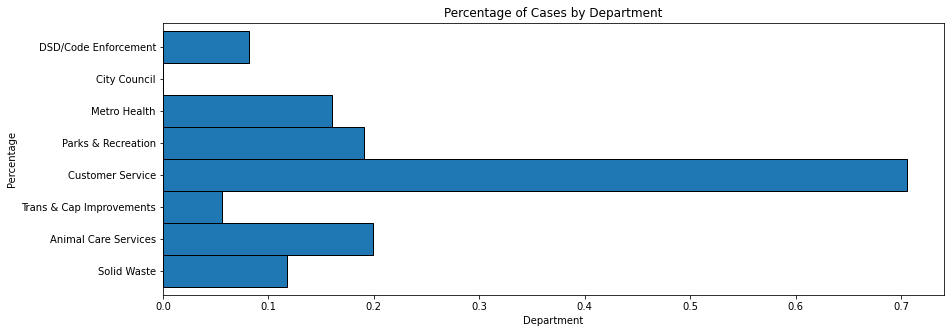

In [32]:
late_by_dept.set_index("department").percentage.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
plt.ylabel('Percentage')
plt.xlabel('Department')
plt.title('Percentage of Cases by Department')
plt.show()

In [27]:
(
    df.groupby('department')
    .pivot('case_late')
    .count()
    .select('department',
            col('true').alias('late'),
            col('false').alias('not_late'),
            (col('true') + col('false')).alias('total_cases'),
             round((col('true') / (col('true') + col('false'))), 3).alias('pct_cases_late'))
    .na.fill(0)
    .sort('department')
    .show(truncate=False)
)

+------------------------+-----+--------+-----------+--------------+
|department              |late |not_late|total_cases|pct_cases_late|
+------------------------+-----+--------+-----------+--------------+
|Animal Care Services    |23276|93639   |116915     |0.199         |
|City Council            |0    |33      |0          |0.0           |
|Customer Service        |2010 |839     |2849       |0.706         |
|DSD/Code Enforcement    |26235|295139  |321374     |0.082         |
|Metro Health            |829  |4334    |5163       |0.161         |
|Parks & Recreation      |3797 |16110   |19907      |0.191         |
|Solid Waste             |32945|246325  |279270     |0.118         |
|Trans & Cap Improvements|5411 |90782   |96193      |0.056         |
+------------------------+-----+--------+-----------+--------------+



## Exercise 3
On average, how late are the late cases by department?

In [9]:
df.groupBy("department").agg(mean("num_days_late").alias("avg_num_days_late")).show()

+--------------------+-------------------+
|          department|  avg_num_days_late|
+--------------------+-------------------+
|         Solid Waste| -2.193864424022545|
|Animal Care Services|-226.16549770717506|
|Trans & Cap Impro...|-20.509793501785314|
|  Parks & Recreation| -5.283345998745901|
|    Customer Service|  59.49019459221518|
|        Metro Health| -4.904223205386017|
|        City Council|               null|
|DSD/Code Enforcement| -38.32346772537388|
+--------------------+-------------------+



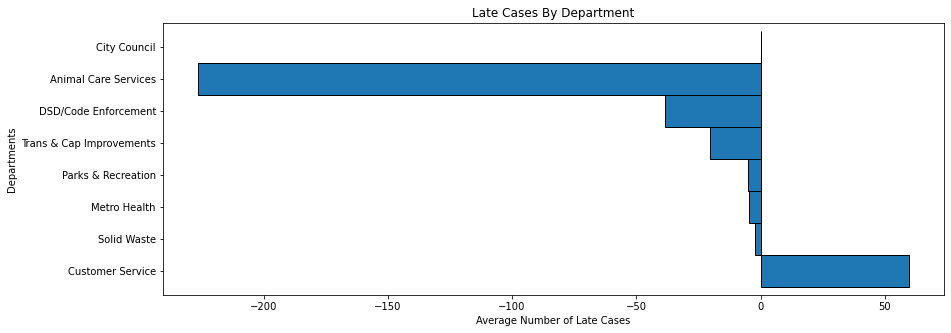

In [10]:
(
    df.groupBy("department")
    .agg(mean("num_days_late").alias("count_num_days_late"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .count_num_days_late.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Number of Late Cases")
plt.ylabel("Departments")
plt.title("Late Cases By Department")
plt.show()

## Exercise 4
What is the service type that is the most late? 

In [11]:
(
    df.groupBy("service_request_type")
    .agg(mean("num_days_late").alias("avg_num_days_late"))
    .toPandas()
    .sort_values('avg_num_days_late')
    .head(10)
)

,service_request_type,avg_num_days_late
256,Engineering Design,-1399.127234
85,Signal Timing Modification By Engineer,-1247.079780
172,Stray Animal,-998.804573
23,Major Park Improvement Install,-280.254624
311,Sidewalk Cost Sharing Program,-184.876261
225,Multi Tenant Exterior,-135.715881
34,CPS Energy Towers,-129.847787
132,CPS Energy Wood Poles,-129.309052
212,CPS Energy Metal Poles,-129.179198
50,Multi Tenant Interior,-125.143186


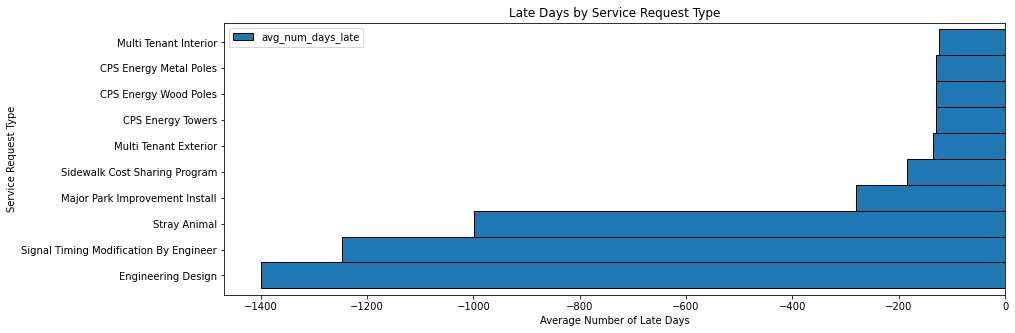

In [12]:
(
    df.groupBy("service_request_type")
    .agg(mean("num_days_late").alias("avg_num_days_late"))
    .toPandas()
    .set_index("service_request_type")
    .sort_values('avg_num_days_late')
    .head(10)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Number of Late Days")
plt.ylabel("Service Request Type")
plt.title("Late Days by Service Request Type")
plt.show()

Just for Parks & Rec?

In [13]:
(
    df.filter(df.department == 'Parks & Recreation')
    .groupby('service_request_type')
    .agg(mean("num_days_late").alias("avg_num_days_late"))
    .toPandas()
    .sort_values('avg_num_days_late')
    .head(10)
)

,service_request_type,avg_num_days_late
3,Major Park Improvement Install,-280.254624
13,Heavy Equipment,-16.755152
40,Pressure Washing,-10.508968
8,Small Equipment Repair,-10.170168
15,Irrigation,-9.613467
11,Landscape Maintenance,-7.136652
39,Playgrounds,-6.624962
23,Heating and Air Conditioning,-5.772702
21,Amenity Park Improvement Int,-5.411794
27,Lake and Ponds Maintenance,-4.785778


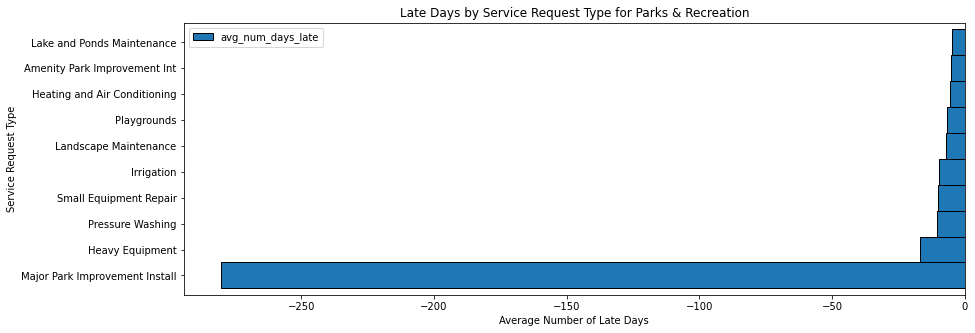

In [14]:
(
    df.filter(df.department == 'Parks & Recreation')
    .groupby('service_request_type')
    .agg(mean("num_days_late").alias("avg_num_days_late"))
    .toPandas()
    .set_index("service_request_type")
    .sort_values('avg_num_days_late')
    .head(10)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)
plt.xlabel("Average Number of Late Days")
plt.ylabel("Service Request Type")
plt.title("Late Days by Service Request Type for Parks & Recreation")
plt.show()

## Exercise 5
For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [15]:
(
    df.filter(df.department == 'DSD/Code Enforcement')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
Overgrown Yard/Trash,65895
Bandit Signs,32910
Front Or Side Yard Parking,28794
Junk Vehicle On Private Property,21473
Alley-Way Maintenance,20214


In [16]:
(
    df.filter(df.department == 'Animal Care Services')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
Stray Animal,26760
Aggressive Animal(Non-Critical),24882
Animal Neglect,13441
Trapped/Confined Animal,11354
Public Nuisance(Own Animal),10715


In [17]:
(
    df.filter(df.department == 'Solid Waste')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
No Pickup,86855
Damaged Cart,30338
Cart Exchange Request,22024
Lost/Stolen Cart,18731
Dead Animal - Dog,16714


In [18]:
(
    df.filter(df.department == 'Trans & Cap Improvements')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
Pot Hole Repair,20616
Traffic Signal Ops and Maintenance - Emergency,7997
Traffic Sign Missing/Down,5674
Base/Pavement Repair,5385
Signal Timing Modification,4414


In [19]:
(
    df.filter(df.department == 'Parks & Recreation')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
Carpentry,1944
Plumbing,1782
Heating and Air Conditioning,1459
Playgrounds,1438
Ballfields,1234


In [20]:
(
    df.filter(df.department == 'Metro Health')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
License Renewal Invoice,1349
Hygienic Practices,946
Pests,715
Food Contact Surfaces,602
Public Right of Way,538


In [21]:
(
    df.filter(df.department == 'City Council')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
Request for Research/Information,31
CCO_Request for Research/Information_1,2


In [22]:
(
    df.filter(df.department == 'Customer Service')
    .groupBy('service_request_type')
    .agg(count("service_request_type").alias("num_of_request"))
    .toPandas()
    .set_index('service_request_type')
    .sort_values('num_of_request', ascending = False)
    .head(5)
)

,num_of_request
service_request_type,
Complaint,2388
Compliment,461


## Exercise 6
Does whether or not its a weekend matter for when a case is opened/closed?

In [3]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [4]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [5]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [6]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)

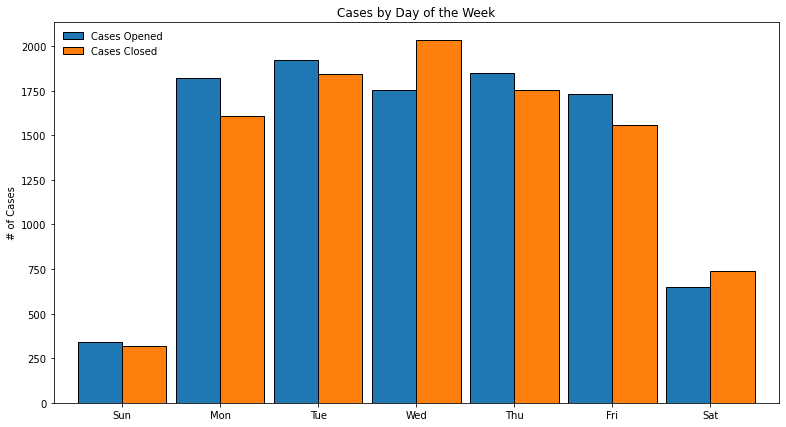

In [12]:
days_of_the_week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
ind = [x for x, _ in enumerate(days_of_the_week)]

ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.xticks(ind, days_of_the_week, rotation=0)
plt.title('Cases by Day of the Week')
plt.xlabel('')
plt.ylabel('# of Cases')
plt.legend(labels = ('Cases Opened', 'Cases Closed'), loc='upper left', frameon=False)
plt.show()

## Exercise 7
On average, how many cases are opened a day for the Customer Service department?

In [28]:
(df.filter(df.department == "Customer Service")
 .filter(df.case_status == 'Open').count()
) / len(ts)

1.9914529914529915

## Exercise 8
Does the number of service requests for the solid waste department vary by day of the week?

In [47]:
waste_request_by_day = (
    df.filter(df.department == 'Solid Waste')
    .select(
        "service_request_type",
        date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date")
            )
)

In [48]:
waste_request_opened_by_day = pd.DataFrame(
    waste_request_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)

In [49]:
waste_request_opened_by_day

,count
case_opened_date,
2017-01-01,43
2017-01-02,722
2017-01-03,771
2017-01-04,545
2017-01-05,586
...,...
2018-08-04,175
2018-08-05,90
2018-08-06,775


In [50]:
waste_request_opened_by_day['weekday'] = waste_request_opened_by_day.index.strftime('%w-%a')

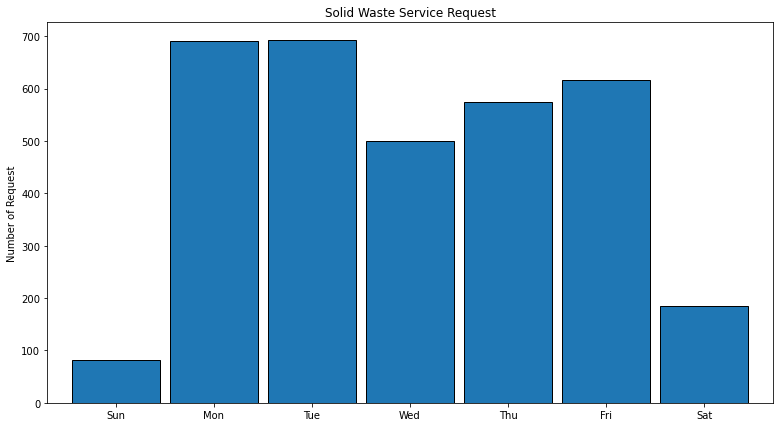

In [76]:
days_of_the_week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
ind = [x for x, _ in enumerate(days_of_the_week)]


waste_request_opened_by_day.groupby('weekday').mean().plot.bar(figsize = (13,7), ec = 'black', width = .9)
plt.title('Solid Waste Service Request')
plt.xlabel('')
plt.ylabel('Number of Request')
plt.legend().remove()
plt.xticks(ind, days_of_the_week, rotation=0)
plt.show()